In [4]:
import os 
import time
import re
import pandas as pd 
import spacy
from datetime import date

import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt

from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.firefox.options import Options
#from selenium.webdriver.common.keys import Keys

nlp = spacy.load('en_core_web_sm', disable=['parser', 'lemmatizer', 'tagger'])

# if i scrape NPR The head needs to be on 

In [22]:
def start_selenium(source, url):
    options = Options()
    #options.headless = True
    driver = webdriver.Firefox(executable_path='/home/stephbuon/projects/entascope/geckodriver', options=options)
    driver.get(url)

    if source == 'FOX':
        
        #search_archive(driver)

        if 'q=coronavirus' in url:
            b = '.load-more'
        
        WebDriverWait(driver, 1).until(EC.element_to_be_clickable((By.CSS_SELECTOR, ".load-more > a:nth-child(1)"))).click()
        for i in range(20): # 499
            try:
                driver.find_element(By.CSS_SELECTOR, '.pf-widget-close').click()
            except:
                pass

            try:
                driver.execute_script("arguments[0].scrollIntoView();", WebDriverWait(driver, 1).until(EC.visibility_of_element_located((By.CSS_SELECTOR, ".load-more > a:nth-child(1)"))))
                WebDriverWait(driver, 1).until(EC.element_to_be_clickable((By.CSS_SELECTOR, ".load-more > a:nth-child(1)"))).click()
            except Exception as e2: 
                print(e2)
                print('click number ' + str(i))
                pass

    if source == 'NPR':
        scroll_number = 100 #250
        for i in range(1, scroll_number):
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(1)

            try:
                driver.find_element(By.CSS_SELECTOR, '.global-modal__dismiss').click()
            except:
                pass
    
    return driver.page_source


def validate_url(page_url, source):
    if source == 'FOX':
        if not 'https' in page_url:
            if '/politics/' in page_url or '/media/' in page_url or '/us/':
                page_url = 'https://www.foxnews.com' + page_url            # make sure there are no doubles 
                return requests.get(page_url)
        elif 'q=coronavirus' in page_url:
            return requests.get(page_url)
    else:
        return requests.get(page_url)


def correct_entity_labels(named_entites):
    # d- and r- are recategorized to represent democrat or republican

    coronavirus = re.compile(r'covid|coronavirus|vaccine|omicron|delta|vaccinate|vaxx|pandemic|mask', re.IGNORECASE)
    vaccines = re.compile(r'pfizer|moderna', re.IGNORECASE)
    people = re.compile(r'warren|trump|psaki|palin', re.IGNORECASE)
    organizations = re.compile(r'd-.*|r-.*', re.IGNORECASE) 
    locations = re.compile(r'eswatini', re.IGNORECASE)

    for index, row in named_entites.iterrows():
        row['entity_label'] = 'EVENT' if (re.match(coronavirus, row['entity_text'])) else row['entity_label']
        row['entity_label'] = 'ORG' if (re.match(vaccines, row['entity_text'])) else row['entity_label']
        row['entity_label'] = 'PERSON' if (re.match(people, row['entity_text'])) else row['entity_label']
        row['entity_label'] = 'GPE' if (re.match(organizations, row['entity_text'])) else row['entity_label']
        row['entity_label'] = 'GPE' if (re.match(locations, row['entity_text'])) else row['entity_label']
    
    return named_entites


def export_data(export_path, scraped_pages, out, source, ts):

    if not os.path.exists(export_path + ts):
        os.mkdir(export_path + ts)

    citations = pd.DataFrame(
    {'url': scraped_pages.keys(), 'source': scraped_pages.values()} )

    clean_stuff = pd.DataFrame(citations['source'].tolist(), columns=['source', 'article_id'])

    del(citations['source'])
    citations = pd.concat([citations, clean_stuff], axis=1)

    if not os.path.isfile(export_path + ts + '/' + 'citations_' + source + '_' + ts + '.csv'):
        citations.to_csv(export_path + ts + '/' + 'citations_' + source + '_' + ts + '.csv', index = False)
    else:
        old_citations = pd.read_csv(export_path + ts + '/' + 'citations_' + source + '_' + ts + '.csv')
        citations = pd.concat([citations, old_citations], ignore_index = True)

        citations.to_csv(export_path + ts + '/' + 'citations_' + source + '_' + ts + '.csv', index = False)

    named_entites = pd.DataFrame(
        {'entity_label': out.keys(), 'entity_text': out.values() } )
            
    named_entites = named_entites.explode('entity_text')
    named_entites = correct_entity_labels(named_entites)

    if not os.path.isfile(export_path + ts + '/' + 'named_entities_' + source + '_' + ts + '.csv'):
        named_entites.to_csv(export_path + ts + '/' + 'named_entities_' + source + '_' + ts + '.csv')
    else:
        old_named_entities = pd.read_csv(export_path + ts + '/' + 'named_entities_' + source + '_' + ts + '.csv')
        named_entites = pd.concat([named_entites, old_named_entities], ignore_index = True)

        named_entites.to_csv(export_path + ts + '/' + 'named_entities_' + source + '_' + ts + '.csv', index = False)
    


    #sentences_df = pd.DataFrame(
    #    {'id': sentences_dict.keys(), 'sentence': sentences_dict.values() } )
            
    #named_entites = named_entites.explode('sentence')
    #named_entites = correct_entity_labels(named_entites)

    #if not os.path.isfile(export_path + ts + '/' + 'article_text_' + source + '_' + ts + '.csv'):
    #    sentences_df.to_csv(export_path + ts + '/' + 'article_text_' + source + '_' + ts + '.csv', index = False)
    #else:
    #    sentences_df.to_csv(export_path + ts + '/' + 'article_text_' + source + '_' + ts + '.csv', header = False, index = False, mode = 'a')



def show_entity_labels():
    print("""
    PERSON:        People's names
    NORP:          Nationalities or religiouse or political groups.
    FAC:           Infrastructure such as buildings, airports, highways, bridges, etc.
    ORG:           Companies, agencies, institutions, etc.
    GPE:           Countries, cities, states.
    LOC:           Non-GPE locations, mountain ranges, bodies of water. 
    PRODUCT:       Objects, vehicles, foods, etc. (Not services.)
    EVENT:         Names of events. Natural disasters, battles, sports events, etc. Coronavirus strains like "omicron" are categorized as events.
    WORK_OF_ART:   Titles of books, songs, etc.
    LAW:           Names of documents made into laws.
    LANGUAGE:      Named languages.
    DATE:          Absolute or relative dates or periods.
    TIME:          Times smaller than a day.
    PERCENT:       Percentage, including "%".
    MONEY:         Monetary values.
    QUANTITY:      Measurements, as of weight or distance.
    ORDINAL:       Terms denoting order, such as "first" or "second."
    CARDINAL:      Numerals that do not fall under another time. 
    """)


def clean_entities(ls):
    ls = [str(word) for word in ls]

    ls = [word.lower() for word in ls]
    
    ls = [re.sub(r'^the ', '', word) for word in ls]
    ls = [re.sub(r'\'s', '', word) for word in ls]
    ls = [re.sub(r's\'', 's', word) for word in ls]

    remove_image_credits = ['photo', 'getty', 'flickr']
    ls = [sa for sa in ls if not any(sb in sa for sb in remove_image_credits)]

    remove_news_outlets = re.compile(r'fox|abc|associated press|reuters|cnn|\bap\b|npr|nbc')
    # re.match matches the start of the string, while re.search looks for the pattern at any point in the string
    ls = [sa for sa in ls if not re.search(remove_news_outlets, sa)]
    
    return ls


def count_words(clean_data):
    ngrams_dict = {}
    for ngram in clean_data:
        if ngram in ngrams_dict:
            ngrams_dict[ngram] += 1
        else:
            ngrams_dict[ngram] = 1
    
    return ngrams_dict


def time_stamp():
    today = date.today()
    d_today = today.strftime("%m-%d-%Y")

    return d_today


def barplot_entities(df, ts, filter, source):
    df = df[df['entity_label'] == filter]
    df = df['entity_text'].tolist()
    df = clean_entities(df)
    df = count_words(df)
    df = pd.DataFrame(
    {'word': df.keys(), 'count': df.values() } )
    
    df = df[:80].copy()
    df.sort_values(by = ['count'], inplace = True, ascending = True)

    plt.barh(df['word'], df['count'])
    plt.ylabel(filter + ' Name')
    plt.title('Top ' + filter + 's Mentioned in ' + source + ' News Articles about Covid-19' )

    plt.rcParams["figure.figsize"] = [10,20]

    plt.savefig('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + source + '_' + filter + '.pdf')
    plt.show()
    plt.close()


def scraper(response, source, ts, **kwargs):

    kw = kwargs.get('existing_set', None)
    

    keyword = re.compile(r'covid|coronavirus|vaccine|omicron|delta|vaccinat|vaxx|pandemic|mask', re.IGNORECASE)

    start_page = BeautifulSoup(response, 'html.parser')
    
    #if existing_citations:
    #    recorded_sites = {}
    #else:
    recorded_sites = {}
    
    if kw is not None:
        scraped_pages_df = pd.read_csv('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + 'citations_' + source + '_' + ts + '.csv')
        scraped_pages_df['url'] = scraped_pages_df['url'].apply(lambda x: x.split('/')[-1])
        

        scraped_pages = dict(zip(scraped_pages_df['url'], scraped_pages_df['source']))
        
        max_no = scraped_pages_df['article_id'].max()

    else:
        scraped_pages = {}
        max_no = None

    out = {}

    #sentences_dict = {}

    article = 0
    cycle = 0
    for link in start_page.findAll('a'):

        if 'href' in str(link):

            page_url = link['href']

            if keyword.search(page_url):

                if not page_url.split('/')[-1] in scraped_pages.keys():
                    
                    cycle = cycle + 1
                    
                    if max_no is not None:
                        if cycle == 1:
                            article = max_no + 1
                        else:
                            article = article + 1

                    else:
                        article = article + 1

                    if source == 'FOX':
                        if '/politics/' in page_url or '/media/' in page_url or '/us/': #
                            if not 'https' in page_url: # 
                                record = 'https://www.foxnews.com' + page_url  #
                                recorded_sites[record] = [source, article] #
                        elif 'q=coronavirus' in page_url:
                            recorded_sites[page_url] = [source, article]
                    else: 
                        recorded_sites[page_url] = [source, article]

                    scraped_pages[page_url] = source
                    
                    next_page = validate_url(page_url, source) # only needed for politics 
                    
                    #next_page = requests.get(page_url)
                    if next_page is not None:
                        page_content = BeautifulSoup(next_page.text, 'html.parser')

                        # for every paragraph in the page content (denoted by the "p" anchor)
                        for paragraph in page_content.findAll('p'):
                            paragraph = list(paragraph.stripped_strings)

                            print(paragraph)

                            # each sentence is a list
                            #sentence_count = 0
                            for sentence in paragraph: 

                                #sentence_count = sentence_count + 1

                                #sentence_id = str(article) + '-' + str(sentence_count)

                                #if not sentence_id in sentences_dict.keys():
                                #    sentences_dict[sentence_id] = sentence
                                #else:
                                #    sentences_dict[sentence_id].append(sentence)

                                sentence = nlp(sentence)

                                for entity in sentence.ents:
                                    if not entity.label_ in out.keys():
                                        out[entity.label_] = [entity.text]
                                    else:
                                        out[entity.label_].append(entity.text)
                                            
                    time.sleep(1)
 
   
        else:
            pass
    
    #start_page.quit() # will this turn off driver?
    export_data('/home/stephbuon/projects/entascope/scraped_pages/', recorded_sites, out, source, ts)


def scrape_pages_load_more(url, source, ts, **kwargs):

    existing_set = kwargs.get('existing_set', None)
    
    # selenium is used to activate triggers like "show more" buttons
    # the triggered website is then assigned to response (instead of using requests)
    response = start_selenium(source, url)
    #response = requests.get(url)

    scraper(response, source, ts, existing_set = existing_set)


def scrape_pages_multi_page(url, source, ts):

    keyword = re.compile(r'covid|coronavirus|vaccine|omicron|delta|vaccinat|vaxx|pandemic|mask', re.IGNORECASE)
    
    options = Options()
    #options.headless = True
    driver = webdriver.Firefox(executable_path='/home/stephbuon/projects/entascope/geckodriver', options=options)

    for i in range(5): 
        if source == 'KRISTV':
            url_w_page = url + str(i)

            driver.get(url_w_page)
            
            try:
                try:
                    driver.find_element(By.CSS_SELECTOR, '.MAD_INVIEW_CLOSE').click()
                except:
                    pass

                driver.execute_script("arguments[0].scrollIntoView();", WebDriverWait(driver, .5).until(EC.visibility_of_element_located((By.CSS_SELECTOR, "a.List"))))
                WebDriverWait(driver, .5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "a.List"))).click()

                scraper(driver.page_source, source, ts)
                
            except Exception as e: 
                print(e)
                pass  

In [13]:
from selenium.webdriver.support.ui import Select

def search_archive(driver):

    select = Select(driver.find_element(By.CSS_SELECTOR, 'div.month:nth-child(2) > ul:nth-child(2)'))
    
    select.select_by_value('1')

In [23]:
ts = time_stamp()
scrape_pages_load_more('https://www.foxnews.com/search-results/search?q=coronavirus', 'FOX', ts, existing_set = True)

# the scroll page for msbnc: https://www.msnbc.com/opinion/columnists

#existing_citations 
#https://www.npr.org/sections/news/archive
#https://www.foxnews.com/politics
#https://www.foxnews.com/media
#https://www.foxnews.com/search-results/search?q=coronavirus

#https://www.foxnews.com/politics

/tmp/ipykernel_5308/841149642.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Firefox(executable_path='/home/stephbuon/projects/entascope/geckodriver', options=options)


Message: 

click number 8
Message: 

click number 9
Message: 

click number 10
Message: 

click number 11
Message: 

click number 12
Message: 

click number 13
Message: 

click number 14
Message: 

click number 15
Message: 

click number 16
Message: 

click number 17
Message: 

click number 18
Message: 

click number 19


In [ ]:
#def log_urls(source, url):
#    if source == 'FOX':
#        if 'q=coronavirus' in url:
#            pass
#        elif 

In [20]:
ts = time_stamp()
scrape_pages_multi_page('https://www.kristv.com/?00000169-7dca-d05d-ab6f-7fdbf8990001-page=', 'KRISTV', ts)
# its not under us, its under politics 
#scrape_pages('https://www.foxnews.com/politics', 'FOX', ts)

/tmp/ipykernel_5094/1445053184.py:298: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Firefox(executable_path='/home/stephbuon/projects/entascope/geckodriver', options=options)


Message: Browsing context has been discarded
Stacktrace:
WebDriverError@chrome://marionette/content/error.js:181:5
NoSuchWindowError@chrome://marionette/content/error.js:415:5
assert.that/<@chrome://marionette/content/assert.js:460:13
assert.open@chrome://marionette/content/assert.js:168:4
GeckoDriver.prototype.findElement@chrome://marionette/content/driver.js:1615:10
despatch@chrome://marionette/content/server.js:291:40
execute@chrome://marionette/content/server.js:264:16
onPacket/<@chrome://marionette/content/server.js:237:20
onPacket@chrome://marionette/content/server.js:238:9
_onJSONObjectReady/<@chrome://marionette/content/transport.js:504:20



WebDriverException: Message: Failed to decode response from marionette


In [62]:
ts = time_stamp()
fox_ne = pd.read_csv('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + 'named_entities_FOX_' + ts +'.csv')
#msnbc_ne = pd.read_csv('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + 'named_entities_MSNBC_' + ts +'.csv')
#npr_ne = pd.read_csv('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + 'named_entities_NPR_' + ts +'.csv')

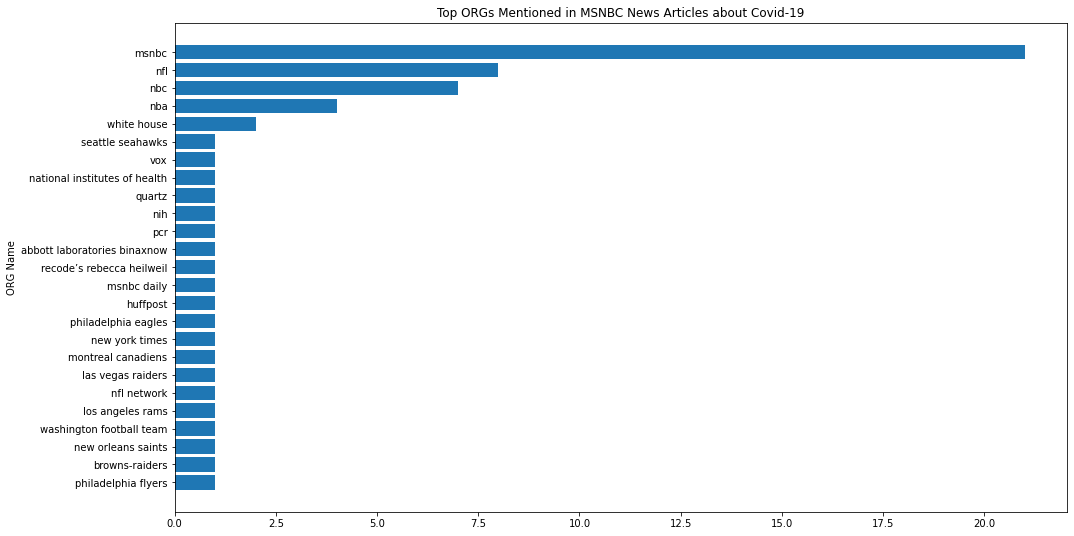

In [23]:
barplot_entities(msnbc_ne, ts, 'ORG', 'MSNBC') # cut off the 's 

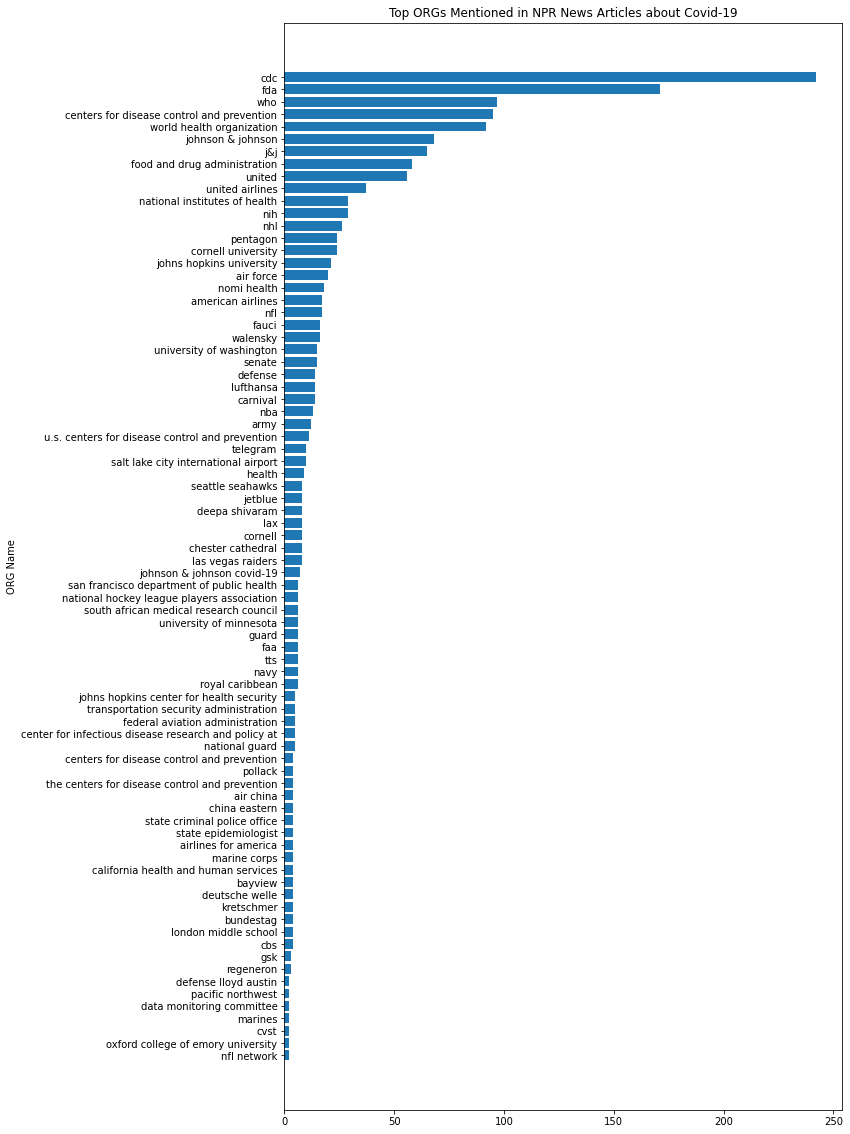

In [8]:
npr_ne = pd.read_csv('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + 'named_entities_NPR_' + ts +'.csv')
barplot_entities(npr_ne, ts, 'ORG', 'NPR') # cut off the 's 

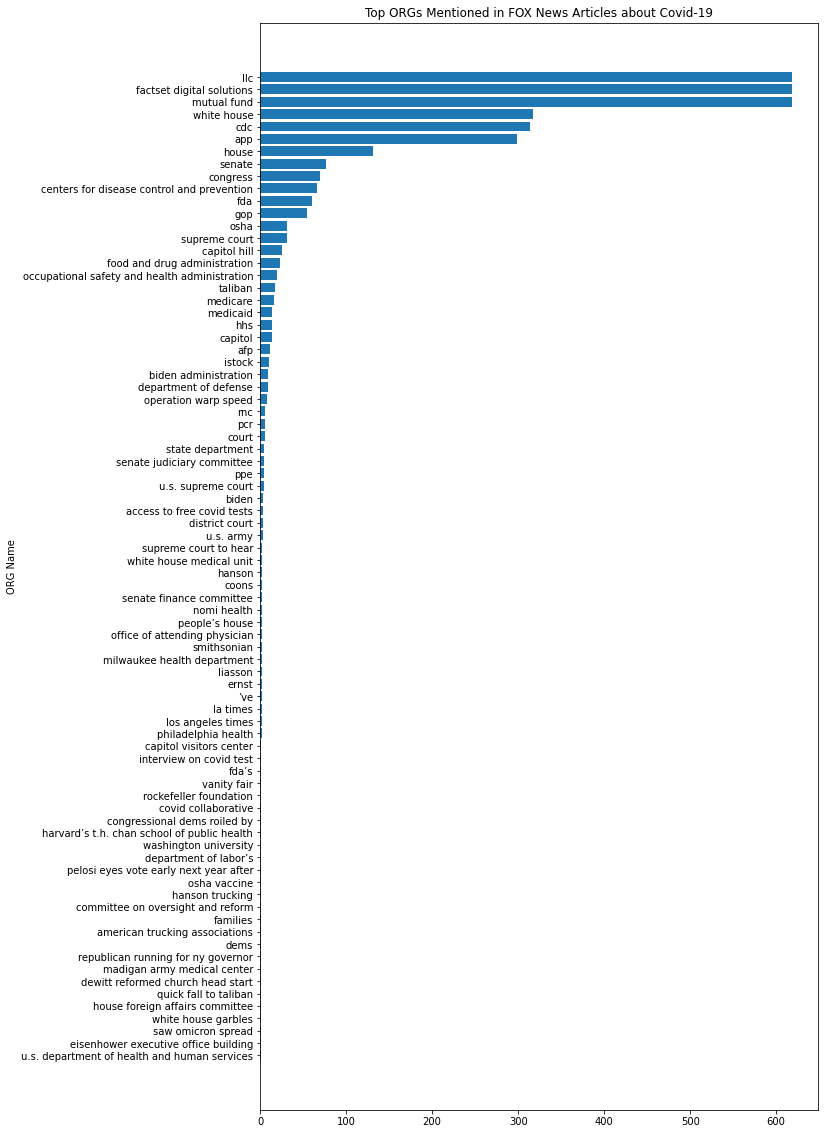

In [67]:
entities = ['EVENT', 'LAW', 'ORG']

#for entity in entities:
barplot_entities(fox_ne, ts, 'ORG', 'FOX')

In [42]:
barplot_entities(fox_ne, 'PRODUCT', 'FOX')

TypeError: barplot_entities() missing 1 required positional argument: 'source'

In [ ]:
urls = ['https://www.npr.org/sections/news/', 'https://www.msnbc.com/', 'https://www.foxnews.com/']
sources = ['NPR', 'MSNBC', 'FOX']
ts = time_stamp()

#for url in urls:
#    for source in sources:
        #scrape_pages(url, source, ts)

scrape_pages('https://www.npr.org/sections/news/', 'NPR', ts)
scrape_pages('https://www.msnbc.com/', 'MSNBC', ts)
scrape_pages('https://www.foxnews.com/', 'FOX', ts)

In [14]:
# i want NORP 
# i want LOC
# GPE
# PERSON
# EVENT 
# ORG